# Ising model

Here we consider inference on an Ising model.
First we import the code and set some plotting parameters.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time,os
sys.path.insert(1, '../../src/')
from discrete_mixflows import *
from gibbs import *
from concrete import *
import aux
from meanfield import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='../../../madmix-tex/fig/'

## 1D model

The one dimensional Ising model considers a target distribution $\pi(x)$
on $\mathcal{X}=\{-1,1\}^M$ such that
$$
    \pi(x)\propto\exp\left\{\beta\sum_{m=1}^{M-1} x_m x_{m+1}\right\},
$$
where $\beta>0$ is an inverse temperature parameter.
The normalizing constant is generally intractable since it involves a sum over $2^M$ terms
but the full conditionals $\pi_m$ can be calculated in closed form.
Specifically, for the particles $x_1$ and $x_M$ the full conditional
only depends on their only neighbors:
$$
    \pi_1(x)=\frac{\exp(\beta x x_2)}{2\cosh(\beta)},\qquad
    \pi_M(x)=\frac{\exp(\beta x x_{M-1})}{2\cosh(\beta)}.
$$
The normalizing constant is tractable since it involves adding over two terms only
and can be simplified since $\cosh(\beta)=\cosh(-\beta)$.
The probability for particles with two neighbors 
$x_m,  m\neq1,M$ is likewise given by
$$
    \pi_m(x)=\frac{\exp(\beta x (x_{m-1} + x_{m+1}))}{2\cosh(\beta (x_{m-1}+x_{m+1}))}.
$$

We consider an instantiation with $M=5$ particles
that starts at a uniform distribution over the $2^M$ possible arrangements.
For simplicity, we consider an inverse temperature of $\beta=1$.

In [110]:
########################
########################
# target specification #
########################
########################
M=5 # number of particles

# target
beta=1. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [111]:
x=idx_unflattenBinary(np.arange(0,2**M),M)
lprbs=lp(x)
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)
prbs_smallM=np.copy(prbs)
smallM=5

In [4]:
########################
########################
#    Mad Mix approx    #
########################
########################
madmix_elbos = -np.inf*np.ones(2)
madmix_cput  =  np.inf*np.ones(2)

# reference specification
lq0 = lambda x,u : -M*np.log(2)*np.ones(x.shape[1])
def randq0(size): 
    tmpx=np.random.randint(low=0,high=2,size=(M,size))
    return tmpx,np.random.rand(M,size)

# settings
N=1000
xi=np.pi/16
x=idx_unflattenBinary(np.arange(0,2**M),M)

In [5]:
t0=time.perf_counter()
qvar_smallM=np.exp(lqN(x,np.random.rand(M,2**M),N=N,lq0=lq0,lp=lp,xi=xi))
madmix_cput[0]=time.perf_counter()-t0

In [6]:
# compute ELBO
elbo_qN_smallM=elbo_exact(np.log(qvar_smallM/np.sum(qvar_smallM)),np.log(prbs_smallM))
madmix_elbos[0]=elbo_qN_smallM

In [7]:
########################
########################
#    Gibbs sampling    #
########################
########################
gibbs_elbos = -np.inf*np.ones(2)
gibbs_cput  =  np.inf*np.ones(2)

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=2,size=M)

t0=time.perf_counter()
gibbs_samples_smallM=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.80,verbose=True)
gibbs_cput[0]=time.perf_counter()-t0

# save samples for dequantization
pkl_save(gibbs_samples_smallM,'sockeye_files/gibbs_samples_smallM')

FileNotFoundError: [Errno 2] No such file or directory: 'sockeye_files/gibbs_samples_smallM.pkl'

In [8]:
# get density and compute ELBO
gibbs_density_smallM=plt.hist(idx_flattenBinary(gibbs_samples_smallM),bins=np.arange(0,2**M+1),density=True)[0]
gibbs_density_smallM[gibbs_density_smallM<1e-32]=1e-32
gibbs_density_smallM=gibbs_density_smallM/np.sum(gibbs_density_smallM)
plt.clf()
elbo_gibbs_smallM=elbo_exact(np.log(gibbs_density_smallM),np.log(prbs_smallM))
gibbs_elbos[0]=elbo_gibbs_smallM

<Figure size 1500x750 with 0 Axes>

In [9]:
########################
########################
#      Mean field      #
########################
########################
meanfield_elbos = -np.inf*np.ones(2)
meanfield_cput  =  np.inf*np.ones(2)

max_iters=10000

t0=time.perf_counter()
mf_density_smallM=meanfieldIsing(smallM,beta,max_iters)
meanfield_cput[0]=time.perf_counter()-t0

mf_density_smallM=np.exp(flattenlq(mf_density_smallM))

In [10]:
# compute ELBO
elbo_meanfield_smallM=elbo_exact(np.log(mf_density_smallM),np.log(prbs_smallM))
meanfield_elbos[0]=elbo_meanfield_smallM

In [11]:
########################
########################
#    dequantization    #
########################
########################
dequant_flows_smallM     = pkl_load('sockeye/dequantization/smallM/ising_flows_dequant')
dequant_losses_smallM    = pkl_load('sockeye/dequantization/smallM/ising_losses_dequant')
dequant_cpu_times_smallM = pkl_load('sockeye/dequantization/smallM/ising_cpu_times_dequant')
dequant_densitycput = np.zeros((2,len(dequant_flows_smallM)))
dequant_sim_size_smallM  = len(dequant_flows_smallM)
dequant_max_iters_smallM = dequant_losses_smallM.shape[-1]
print('Total training time: '+str(dequant_cpu_times_smallM.sum()/3600)+' hours')

Total training time: 26.135657455182503 hours


Text(0.5, 1.0, 'Dequantization RealNVP training loss traceplots')

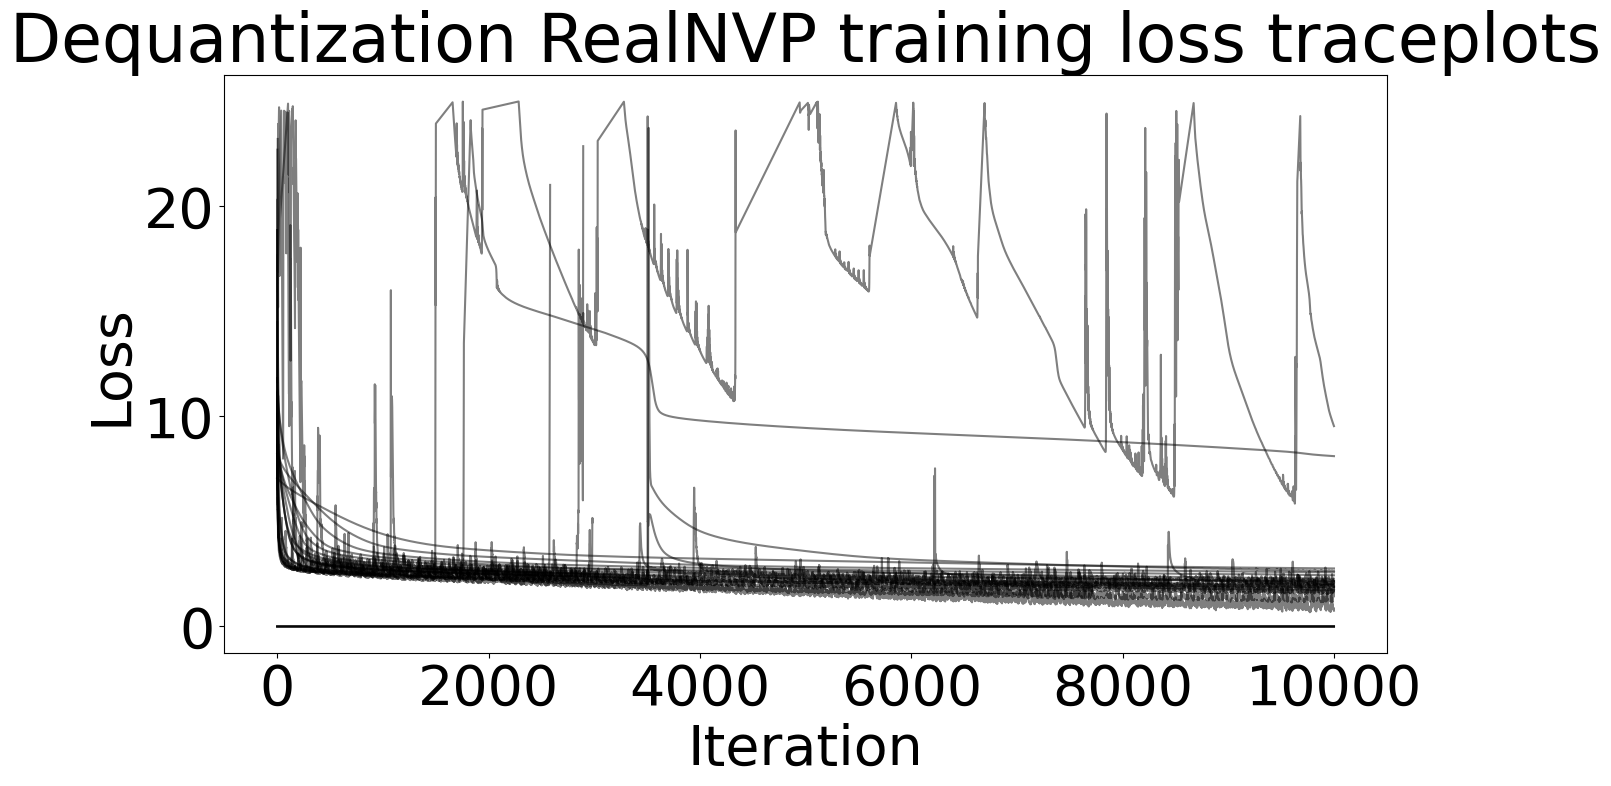

In [12]:
# loss traceplot
threshold=25
for i in range(dequant_sim_size_smallM): plt.plot(np.arange(dequant_max_iters_smallM)[dequant_losses_smallM[i,:]<threshold],dequant_losses_smallM[i,dequant_losses_smallM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Dequantization RealNVP training loss traceplots')

In [13]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
dequant_samples_smallM=np.zeros((dequant_sim_size_smallM,M,sample_size))
dequant_densities_smallM=np.zeros((dequant_sim_size_smallM,2**M))
dequant_elbos_smallM=-np.inf*np.ones(dequant_sim_size_smallM)

for i in range(dequant_sim_size_smallM):
    print(str(i+1)+'/'+str(dequant_sim_size_smallM),end='\r')
    tmp_flow=dequant_flows_smallM[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    t0=time.perf_counter()
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.squeeze(tmp_sample.detach().numpy()) # to numpy
    tmp_sample=np.floor(tmp_sample)                    # quantize
    tmp_sample[tmp_sample<0]=0
    tmp_sample[tmp_sample>1]=1
    dequant_samples_smallM[i,:]=tmp_sample.T.astype(int)
    
    # compute freq density
    tmp_density=plt.hist(idx_flattenBinary(tmp_sample.T),
                         bins=np.arange(0,2**smallM+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    dequant_densities_smallM[i,:]=tmp_density
    dequant_densitycput[0,i]=time.perf_counter()-t0
    
    # estimate elbo
    dequant_elbos_smallM[i]=elbo_exact(np.log(tmp_density),np.log(prbs_smallM))
# end for
plt.clf()

/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Figure size 1500x750 with 0 Axes>

In [14]:
########################
########################
#       Concrete       #
########################
########################
flows_smallM     = pkl_load('sockeye/smallM/ising_flows')
losses_smallM    = pkl_load('sockeye/smallM/ising_losses')
cpu_times_smallM = pkl_load('sockeye/smallM/ising_cpu_times')
concrete_densitycput = np.zeros(len(flows_smallM))
sim_size_smallM  = len(flows_smallM)
max_iters_smallM = losses_smallM.shape[-1]
print('Total training time: '+str(cpu_times_smallM.sum()/3600)+' hours')

Total training time: 141.52918395412144 hours


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

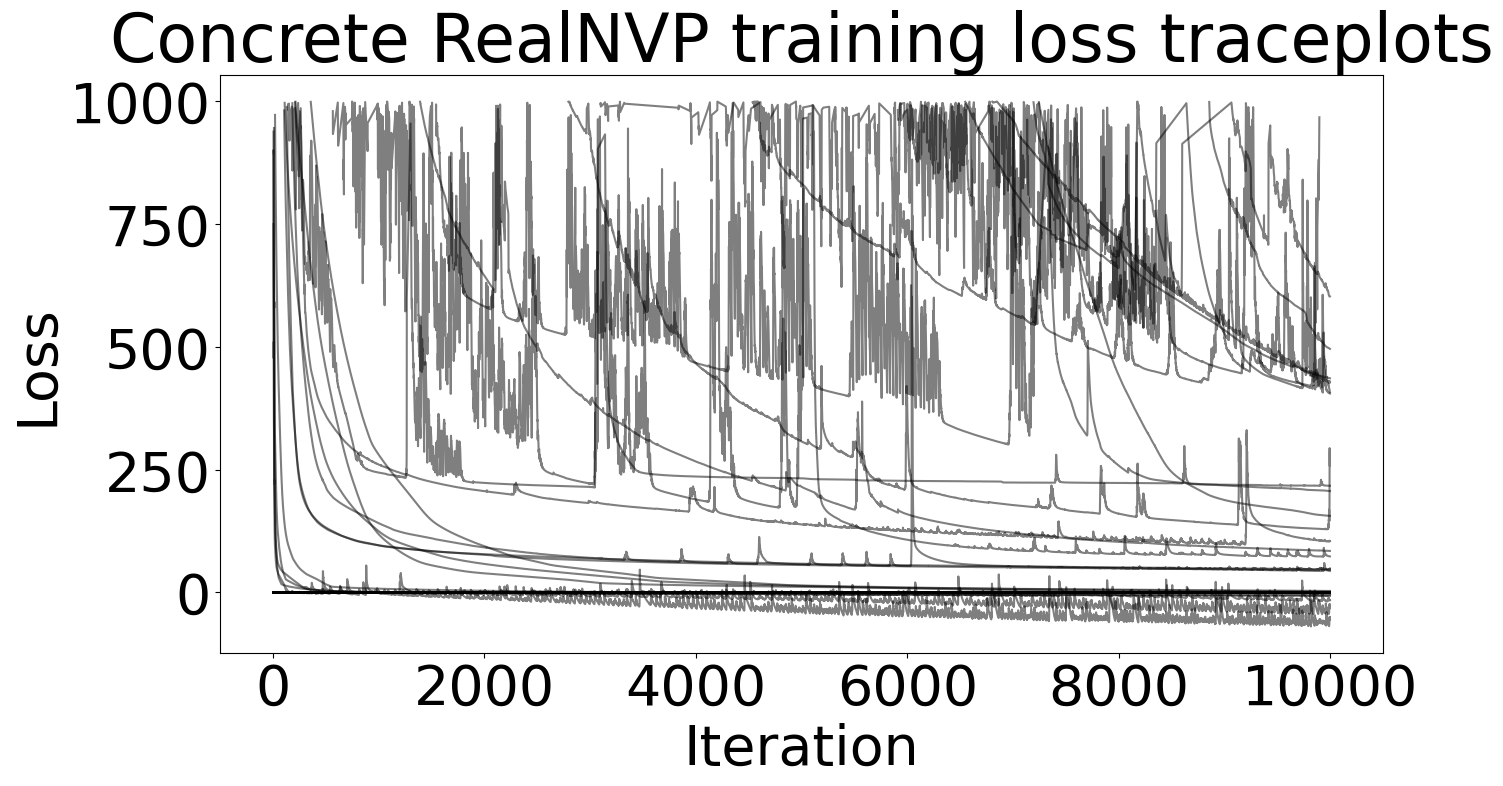

In [15]:
# loss traceplot
threshold=1000
for i in range(sim_size_smallM): plt.plot(np.arange(max_iters_smallM)[losses_smallM[i,:]<threshold],losses_smallM[i,losses_smallM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [16]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples_smallM=np.zeros((sim_size_smallM,M,sample_size))
densities_smallM=np.zeros((sim_size_smallM,2**M))
elbos_smallM=-np.inf*np.ones(sim_size_smallM)

for i in range(sim_size_smallM):
    print(str(i+1)+'/'+str(sim_size_smallM),end='\r')
    tmp_flow=flows_smallM[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    t0=time.perf_counter()
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflattenBinary(tmp_sample,M) # 1d->2d
    samples_smallM[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(idx_flattenBinary(tmp_sample),bins=np.arange(0,2**M+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    tmp_density=tmp_density/np.sum(tmp_density)
    densities_smallM[i,:]=tmp_density
    concrete_densitycput[i]=time.perf_counter()-t0
    
    # estimate elbo
    elbos_smallM[i]=elbo_exact(np.log(tmp_density),np.log(prbs_smallM))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_40346/3192283595.py:20: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_40346/3192283595.py:21: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 1500x750 with 0 Axes>

In [17]:
i_star=np.argmax(elbos_smallM)
print('Optimal flow: '+str(i_star))

Optimal flow: 112


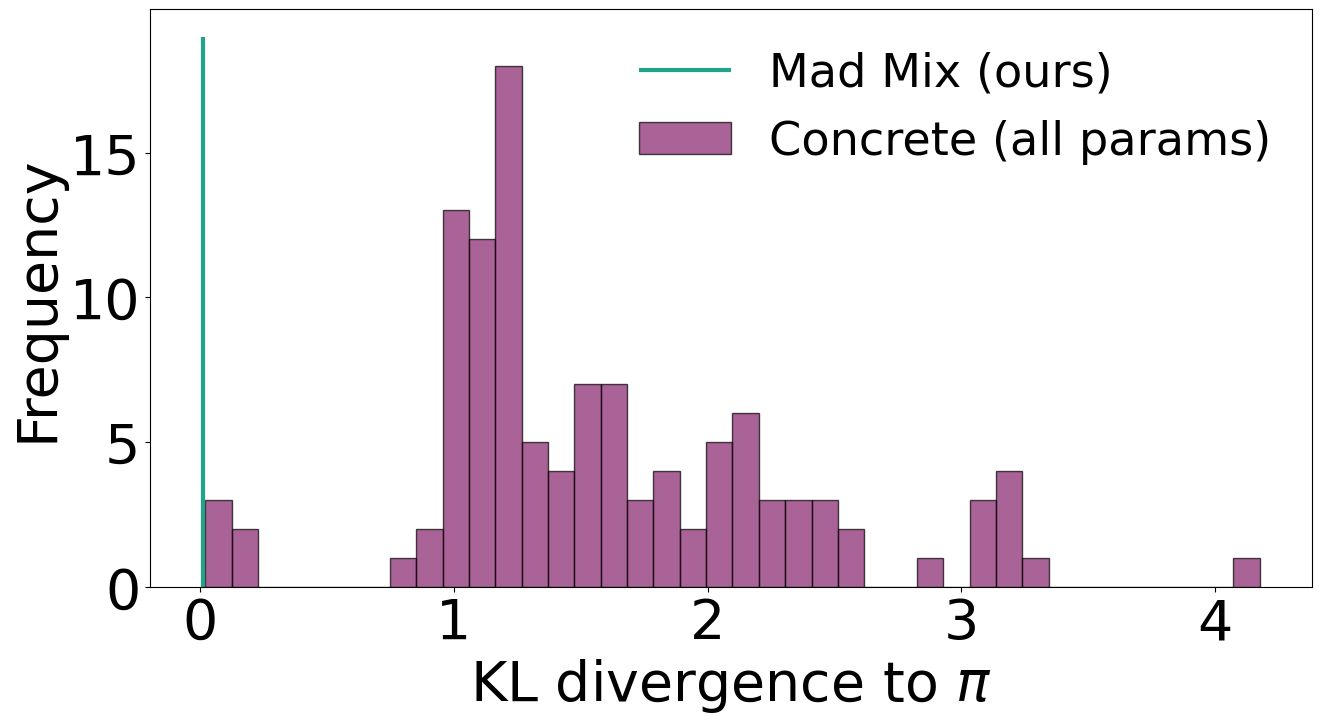

In [18]:
plt.vlines(-elbo_qN_smallM,ymin=0,ymax=19,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos_smallM[-elbos_smallM<5],bins=40,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small',frameon=False)
#plt.savefig(fig_path+'ising_smallM_elbos.pdf', dpi=300, bbox_inches='tight')

In [114]:
########################
########################
#     argmax flows     #
########################
########################
argmax_flows_smallM     = pkl_load('sockeye/argmax/smallM/ising_flows_argmax')
argmax_losses_smallM    = pkl_load('sockeye/argmax/smallM/ising_losses_argmax')
argmax_cpu_times_smallM = pkl_load('sockeye/argmax/smallM/ising_cpu_times_argmax')
argmax_densitycput = np.zeros((2,len(argmax_flows_smallM)))
argmax_sim_size_smallM  = len(argmax_flows_smallM)
argmax_max_iters_smallM = argmax_losses_smallM.shape[-1]
print('Total training time: '+str(argmax_cpu_times_smallM.sum()/3600)+' hours')

Total training time: 23.49353866223039 hours


Text(0.5, 1.0, 'Argmax flows RealNVP training loss traceplots')

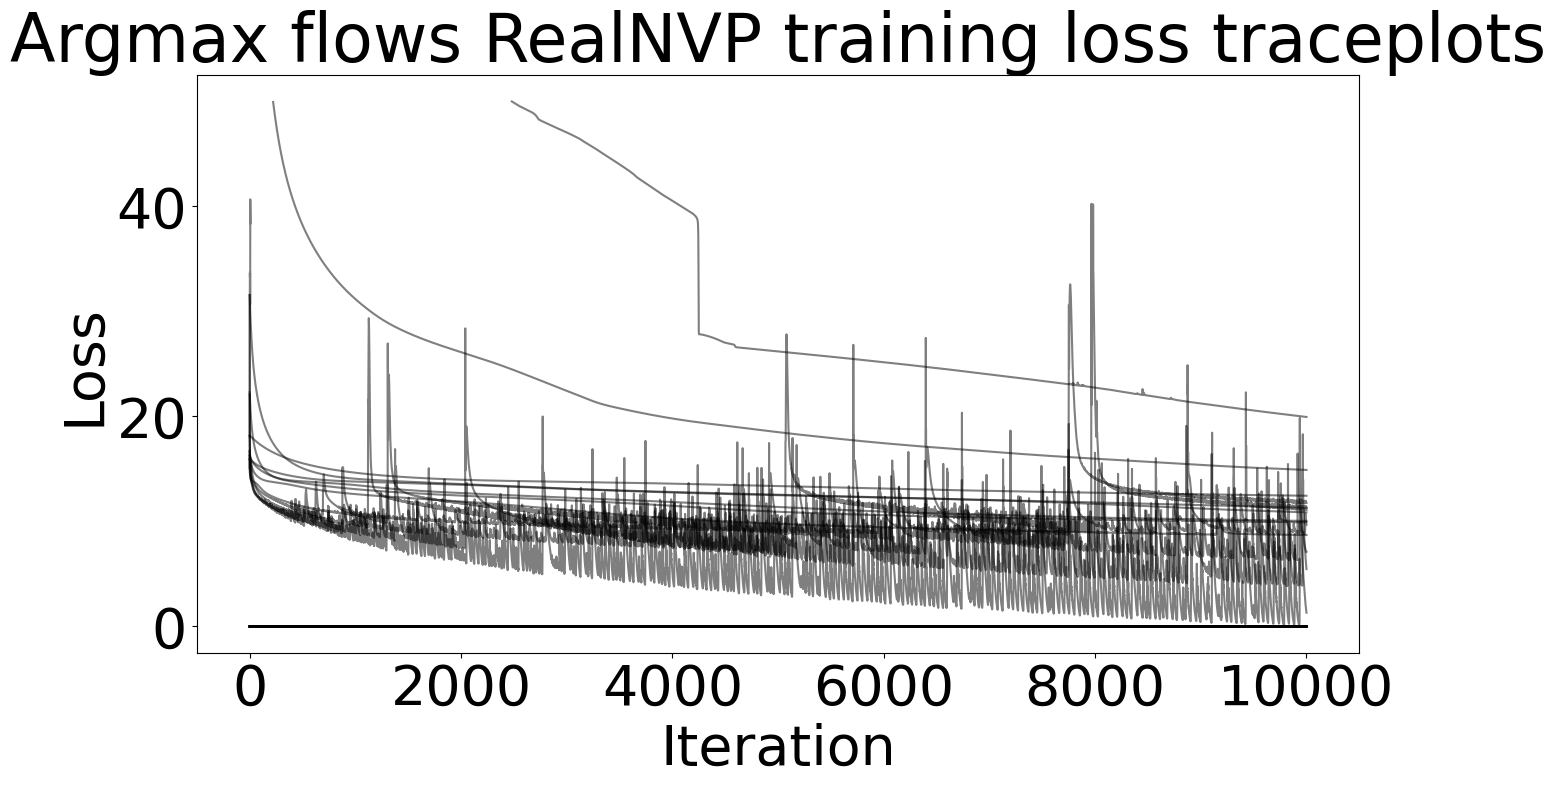

In [115]:
# loss traceplot
threshold=50
for i in range(argmax_sim_size_smallM): plt.plot(np.arange(10001)[argmax_losses_smallM[i,:]<threshold],argmax_losses_smallM[i,argmax_losses_smallM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Argmax flows RealNVP training loss traceplots')

In [117]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
argmax_samples_smallM=np.zeros((argmax_sim_size_smallM, sample_size))
argmax_densities_smallM=np.zeros((argmax_sim_size_smallM,2**smallM))
argmax_elbos_smallM=-np.inf*np.ones(argmax_sim_size_smallM)

for i in range(argmax_sim_size_smallM):
    print(str(i+1)+'/'+str(argmax_sim_size_smallM),end='\r')
    tmp_flow=argmax_flows_smallM[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    t0=time.perf_counter()
    tmp_flow_sample = np.squeeze(tmp_flow.sample(sample_size).detach().numpy())
    tmp_sample = np.zeros((sample_size,smallM))
    for m in range(smallM): tmp_sample[:,m]=np.argmax(tmp_flow_sample[:,2*m+np.arange(2)],axis=1)
    tmp_sample = idx_flattenBinary(tmp_sample.T)
    argmax_samples_smallM[i,:]=tmp_sample.T.astype(int)
    
    # compute freq density
    tmp_density = plt.hist(tmp_sample,
                         bins=np.arange(0,2**smallM+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    argmax_densities_smallM[i,:]=tmp_density
    argmax_densitycput[0,i]=time.perf_counter()-t0
    
    # estimate elbo
    argmax_elbos_smallM[i]=elbo_exact(np.log(tmp_density),np.log(prbs_smallM))
# end for
plt.clf()

<Figure size 1500x750 with 0 Axes>

Text(0, 0.5, 'Probability')

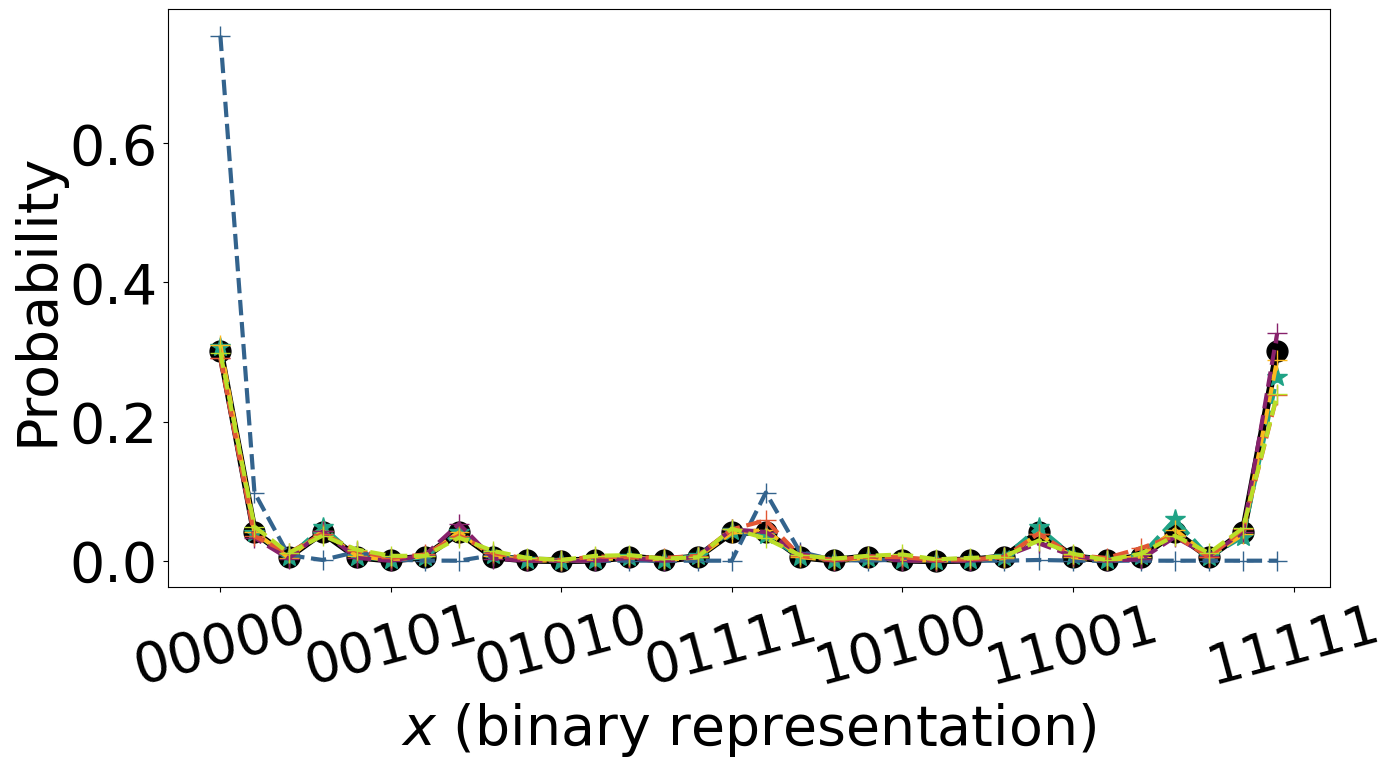

In [118]:
########################
########################
#     plot results     #
########################
########################
ticks=np.arange(0,2**smallM,step=smallM)+0.5
ticks[-1]=2**smallM

ttx=np.arange(0,2**smallM)
plt.plot(ttx+0.5,prbs_smallM,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,qvar_smallM/np.sum(qvar_smallM),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,mf_density_smallM,c='#33638D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,gibbs_density_smallM,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,densities_smallM[np.argmax(elbos_smallM),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,dequant_densities_smallM[np.nanargmax(dequant_elbos_smallM),:],c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,argmax_densities_smallM[np.nanargmax(argmax_elbos_smallM),:],c='#BADE28', label='Argmax flows',lw=3,ls='dashed',ms=15,marker='+')
#plt.legend(fontsize='small',frameon=False)
plt.xlabel('$x$ (binary representation)')
plt.xticks(ticks=ticks,
           labels=[format(int(t), '05b') for t in ticks-0.5],
          rotation=15)
plt.ylabel('Probability')
#plt.savefig(fig_path+'ising_smallM_prbs.pdf', dpi=300, bbox_inches='tight')

## 1D Ising high-dimensional

In [82]:
########################
########################
# target specification #
########################
########################
M=50 # number of particles
largeM=50

# target
beta=5. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [83]:
########################
########################
#    Mad Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : -M*np.log(2)*np.ones(x.shape[1])
def randq0(size): 
    tmpx=np.random.randint(low=0,high=2,size=(M,size))
    return tmpx,np.random.rand(M,size)

# settings
N=500
xi=np.pi/16
size=50

In [84]:
t0=time.perf_counter()
rq_largeM,rqu=randqN(size,N,lp,randq0,xi)
madmix_cput[1]=time.perf_counter()-t0

In [85]:
# ELBO calculation
varq_largeM=lqN(rq_largeM,rqu,N,lq0,lp,xi)
lp_mad = lp(rq_largeM)
mad_elbo_largeM = np.mean(lp_mad-varq_largeM)
madmix_elbos[1] = mad_elbo_largeM

In [86]:
########################
########################
#    Gibbs sampling    #
########################
########################

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=2,size=M)

t0=time.perf_counter()
gibbs_samples_largeM=gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.80,verbose=True)
gibbs_cput[1]=time.perf_counter()-t0

# save samples for dequantization
pkl_save(gibbs_samples_largeM,'sockeye_files/gibbs_samples_largeM')

FileNotFoundError: [Errno 2] No such file or directory: 'sockeye_files/gibbs_samples_largeM.pkl'

In [87]:
# estimate Gibbs prbs
_,gibbs_idx,gibbs_counts=np.unique(gibbs_samples_largeM,axis=1,return_index=True,return_counts=True)
gibbs_prbs=np.zeros(gibbs_ss)+1e-32
gibbs_prbs[gibbs_idx]=gibbs_counts
gibbs_prbs/=np.sum(gibbs_prbs)
gibbs_lp=np.log(gibbs_prbs)

In [88]:
# estimate ELBO
gibbs_elbo_largeM=-np.mean(gibbs_lp-lp(gibbs_samples_largeM))
gibbs_elbos[1]=gibbs_elbo_largeM

In [89]:
########################
########################
#      Mean field      #
########################
########################

max_iters=10000

t0=time.perf_counter()
mf_density_largeM=meanfieldIsing(largeM,beta,max_iters)
meanfield_cput[1]=time.perf_counter()-t0
mf_density_largeM=np.exp(mf_density_largeM)

In [90]:
# create mean field sample
size = 1000
mf_sample = np.zeros((M,size))
for m in range(M): mf_sample[m,:] = np.random.choice(np.array([0,1]),size=size,p=mf_density_largeM[m,:])

In [91]:
# evaluate mean field density on sample
mf_ldensity = np.zeros(size)
for b in range(size): mf_ldensity[b] = np.sum(np.log(mf_density_largeM[np.arange(M),mf_sample[:,b].astype(int)]))

In [92]:
# mean field ELBO
mf_elbo_largeM = np.mean(lp(mf_sample)-mf_ldensity)
meanfield_elbos[1] = mf_elbo_largeM

In [93]:
########################
########################
#    dequantization    #
########################
########################
dequant_flows_largeM     = pkl_load('sockeye/dequantization/largeM/ising_flows_dequant')
dequant_losses_largeM    = pkl_load('sockeye/dequantization/largeM/ising_losses_dequant')
dequant_cpu_times_largeM = pkl_load('sockeye/dequantization/largeM/ising_cpu_times_dequant')
dequant_sim_size_largeM  = len(dequant_flows_largeM)
dequant_max_iters_largeM = dequant_losses_largeM.shape[-1]
print('Total training time: '+str(dequant_cpu_times_largeM.sum()/3600)+' hours')

Total training time: 28.953056040781085 hours


Text(0.5, 1.0, 'Dequantization RealNVP training loss traceplots')

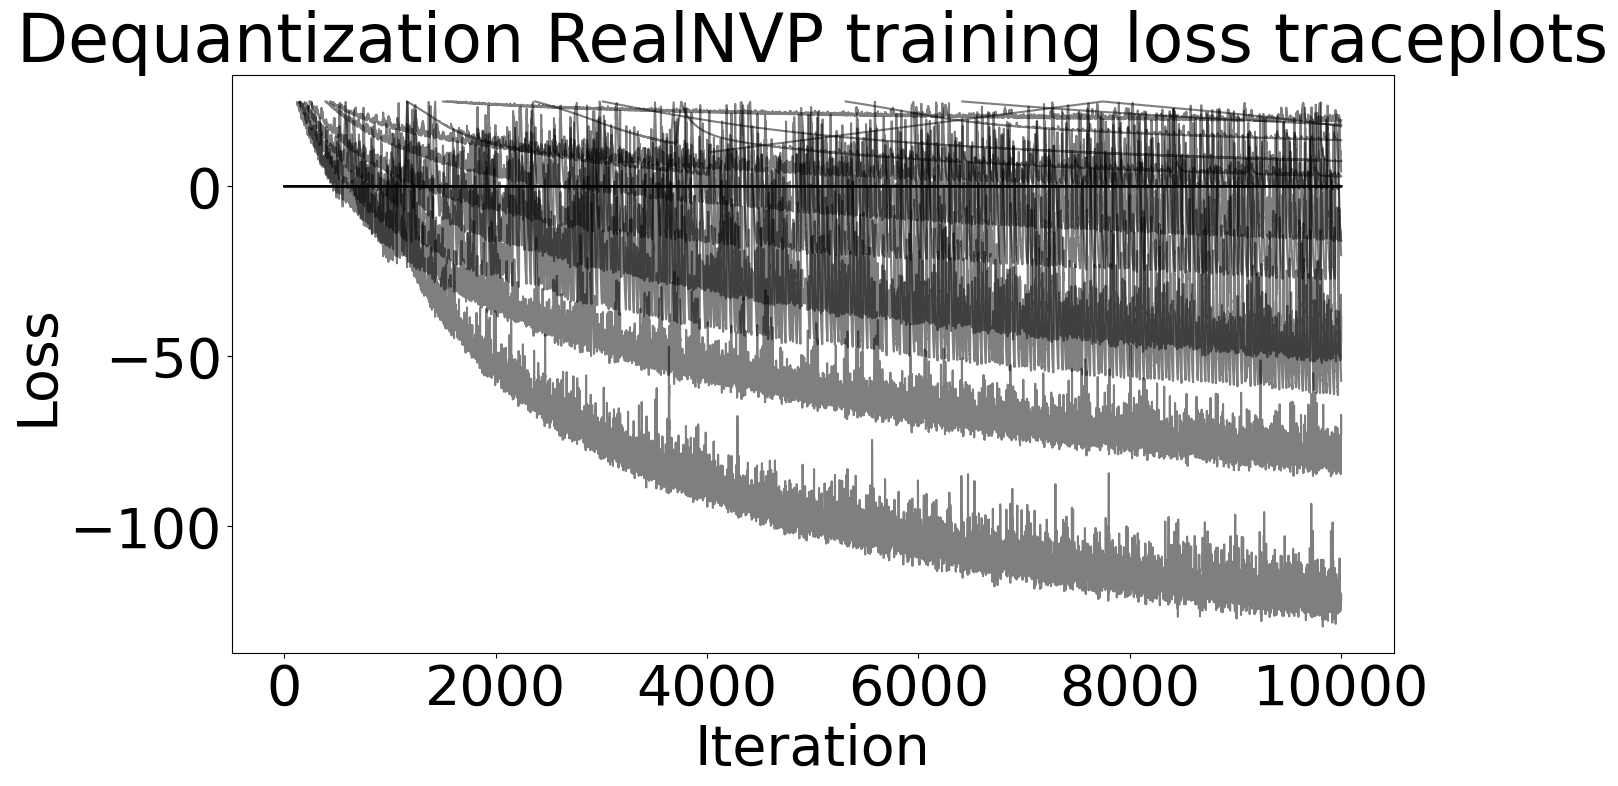

In [94]:
# loss traceplot
threshold=25
for i in range(dequant_sim_size_largeM): plt.plot(np.arange(dequant_max_iters_largeM)[dequant_losses_largeM[i,:]<threshold],dequant_losses_largeM[i,dequant_losses_largeM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Dequantization RealNVP training loss traceplots')

In [95]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
dequant_samples_largeM=np.zeros((dequant_sim_size_largeM,M,sample_size))
dequant_elbos_largeM=-np.inf*np.ones(dequant_sim_size_largeM)

for i in range(dequant_sim_size_largeM):
    print(str(i+1)+'/'+str(dequant_sim_size_largeM),end='\r')
    tmp_flow=dequant_flows_largeM[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    t0=time.perf_counter()
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.squeeze(tmp_sample.detach().numpy()) # to numpy
    tmp_sample=np.floor(tmp_sample).astype(int)        # quantize
    tmp_sample[tmp_sample<0]=0
    tmp_sample[tmp_sample>1]=1
    dequant_samples_largeM[i,:,:]=tmp_sample.T
    
    # compute freq density
    _,dequant_idx,dequant_counts=np.unique(tmp_sample,axis=0,return_index=True,return_counts=True)
    dequant_prbs=np.zeros(sample_size)+1e-32
    dequant_prbs[dequant_idx]=dequant_counts
    dequant_prbs/=np.sum(dequant_prbs)
    dequant_lp=np.log(dequant_prbs)
    dequant_densitycput[1,i]=time.perf_counter()-t0
    
    # estimate elbo
    dequant_elbos_largeM[i]=-np.mean(dequant_lp-lp(tmp_sample.T))
# end for
plt.clf()

<Figure size 1500x750 with 0 Axes>

In [119]:
########################
########################
#     argmax flows     #
########################
########################
argmax_flows_largeM     = pkl_load('sockeye/argmax/largeM/ising_flows_argmax')
argmax_losses_largeM    = pkl_load('sockeye/argmax/largeM/ising_losses_argmax')
argmax_cpu_times_largeM = pkl_load('sockeye/argmax/largeM/ising_cpu_times_argmax')
argmax_sim_size_largeM  = len(argmax_flows_largeM)
argmax_max_iters_largeM = argmax_losses_largeM.shape[-1]
print('Total training time: '+str(argmax_cpu_times_largeM.sum()/3600)+' hours')

Total training time: 19.895243004952757 hours


Text(0.5, 1.0, 'Argmax flows RealNVP training loss traceplots')

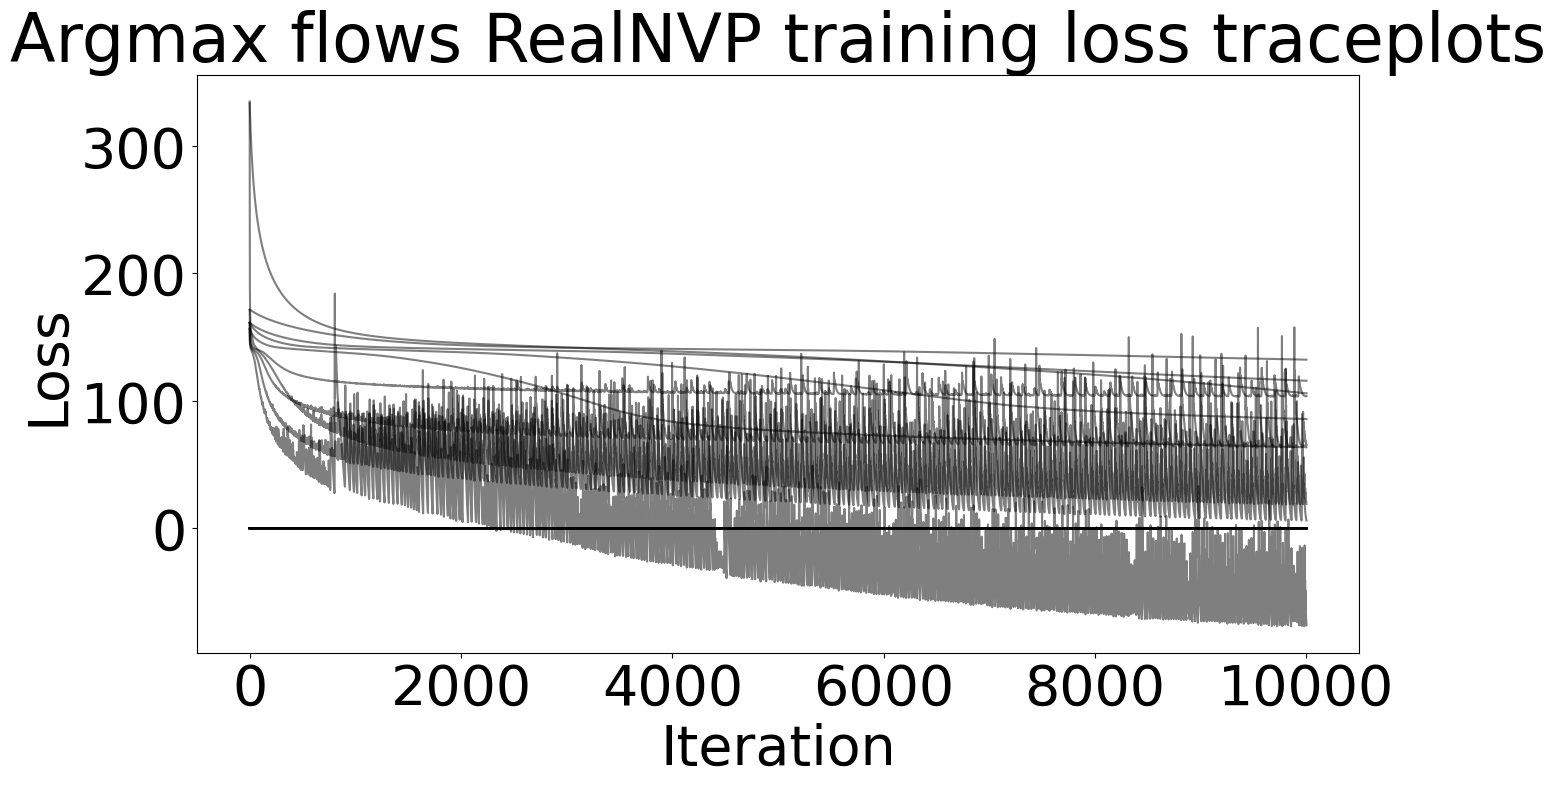

In [120]:
# loss traceplot
threshold=1000
for i in range(argmax_sim_size_largeM): plt.plot(np.arange(10001)[argmax_losses_largeM[i,:]<threshold],argmax_losses_largeM[i,argmax_losses_largeM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Argmax flows RealNVP training loss traceplots')

In [121]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
argmax_samples_largeM=np.zeros((argmax_sim_size_largeM, largeM, sample_size))
argmax_elbos_largeM=-np.inf*np.ones(argmax_sim_size_largeM)

for i in range(argmax_sim_size_largeM):
    print(str(i+1)+'/'+str(argmax_sim_size_largeM),end='\r')
    tmp_flow=argmax_flows_largeM[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    t0=time.perf_counter()
    tmp_flow_sample = np.squeeze(tmp_flow.sample(sample_size).detach().numpy())
    tmp_sample = np.zeros((sample_size,largeM))
    for m in range(largeM): tmp_sample[:,m]=np.argmax(tmp_flow_sample[:,2*m+np.arange(2)],axis=1)
    argmax_samples_largeM[i,:,:]=tmp_sample.T
    
    
    # compute freq density
    _,argmax_idx,argmax_counts=np.unique(tmp_sample,axis=0,return_index=True,return_counts=True)
    argmax_prbs=np.zeros(sample_size)+1e-32
    argmax_prbs[argmax_idx]=argmax_counts
    argmax_prbs/=np.sum(argmax_prbs)
    argmax_lp=np.log(argmax_prbs)
    argmax_densitycput[1,i]=time.perf_counter()-t0
    
    # estimate elbo
    argmax_elbos_largeM[i]=-np.mean(argmax_lp-lp(tmp_sample.T))
# end for
plt.clf()

<Figure size 1500x750 with 0 Axes>

## Save results

In [72]:
# mad mix results
pkl_save(madmix_elbos,'../summary/results/madmix_elbos_ising')
pkl_save(madmix_cput,'../summary/results/madmix_cput_ising')

# gibbs results
pkl_save(gibbs_elbos,'../summary/results/gibbs_elbos_ising')
pkl_save(gibbs_cput,'../summary/results/gibbs_cput_ising')

# mean field results
pkl_save(meanfield_elbos,'../summary/results/meanfield_elbos_ising')
pkl_save(meanfield_cput,'../summary/results/meanfield_cput_ising')

# dequantization results
dequant_elbos=np.vstack((dequant_elbos_smallM,dequant_elbos_largeM))
dequant_cpu_times=np.vstack((dequant_cpu_times_smallM,dequant_cpu_times_largeM))
pkl_save(dequant_elbos,'../summary/results/dequant_elbos_ising')
pkl_save(dequant_cpu_times,'../summary/results/dequant_cput_ising')
pkl_save(dequant_densitycput,'../summary/results/dequant_densitycput_ising')


# concrete results
concrete_elbos=np.copy(elbos_smallM)
concrete_cpu_times=np.copy(cpu_times_smallM)
pkl_save(concrete_elbos,'../summary/results/concrete_elbos_ising')
pkl_save(concrete_cpu_times,'../summary/results/concrete_cput_ising')
pkl_save(concrete_densitycput,'../summary/results/concrete_densitycput_ising')